In [4]:
#! pip install catboost
#! pip install lightgbm
#! pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from pmdarima.arima import auto_arima

In [5]:
## reading train and test data
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [6]:
df = train.copy()
df_test = test.copy()

In [7]:
df.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          813 non-null    object 
 1   Petrol (USD)  811 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.8+ KB


### Missing values

In [9]:
df.isnull().sum()

Date            0
Petrol (USD)    2
dtype: int64

#### Using forwardfill to fill the missing values

In [10]:
df = df.fillna(method = 'ffill')
df.isnull().sum()

Date            0
Petrol (USD)    0
dtype: int64

#### Visualizing target feature

<AxesSubplot:xlabel='Petrol (USD)', ylabel='Density'>

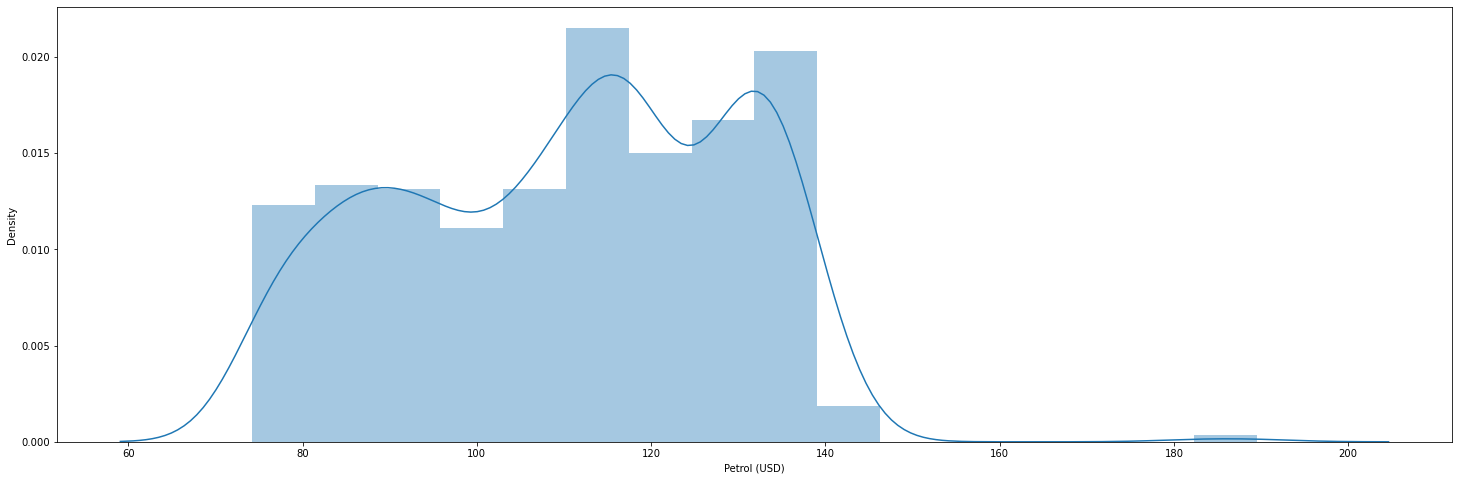

In [11]:
plt.figure(figsize=(25,8))
sns.distplot(df['Petrol (USD)'])

<AxesSubplot:>

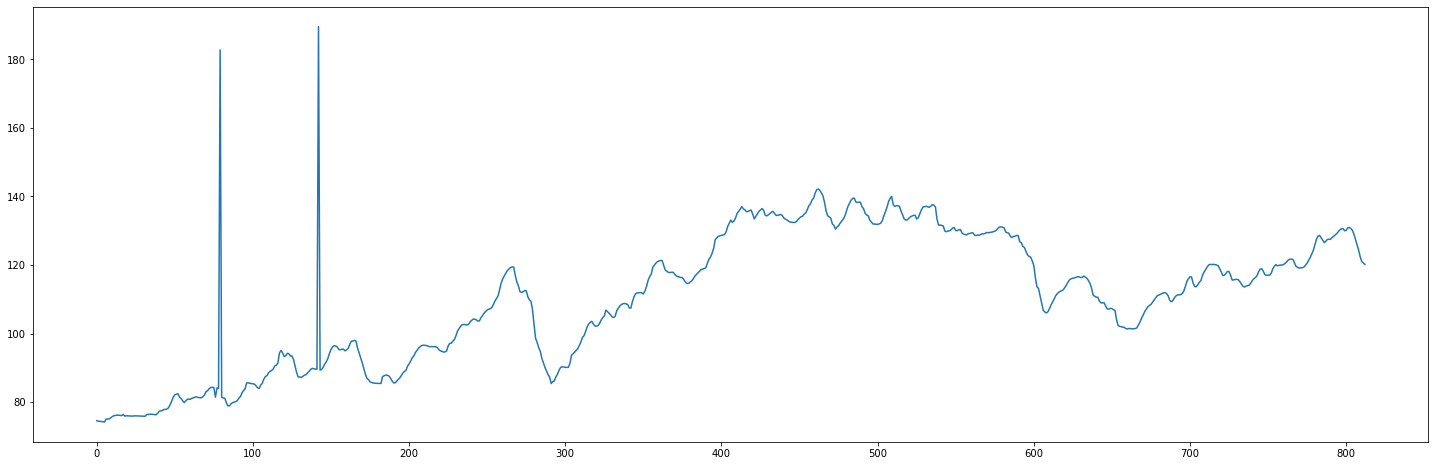

In [12]:
df['Petrol (USD)'].plot(figsize=(25,8))

<AxesSubplot:>

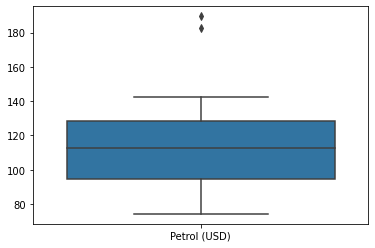

In [13]:
sns.boxplot(data=df)

#### Analysis:

From the above visualization we could note that there are outliers in the dataset.

### Detecting outliers

In [14]:
def outliers(data,col):
    sorted_data = data[col].sort_values(ascending=True)
    quantile1,quantile3 = np.percentile(sorted_data,[25,75])
    iqr = quantile3-quantile1
    lower_bound = quantile1 -(1.5 * iqr) 
    upper_bound = quantile3 +(1.5 * iqr) 
    outliers=[i for i in sorted_data if i<lower_bound or i>upper_bound]
    return outliers

In [15]:
outliers(df,'Petrol (USD)')

[182.73, 189.51]

#### Replacing the outliers with mean of top and bottom row

In [16]:
def mean_value(data,col,num1,num2):
    val = ((data[col][num1]+data[col][num2]))/2
    return val

val_1 = mean_value(train,'Petrol (USD)',78,80)
val_2 = mean_value(train,'Petrol (USD)',141,143)
val_1,val_2

(82.75999999999999, 89.485)

In [17]:
outliers = [182.73, 189.51]
df = df.replace(outliers,[val_1,val_2])
df.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [18]:
df = df.replace([182.73, 189.51],[val_1,val_2])

<AxesSubplot:>

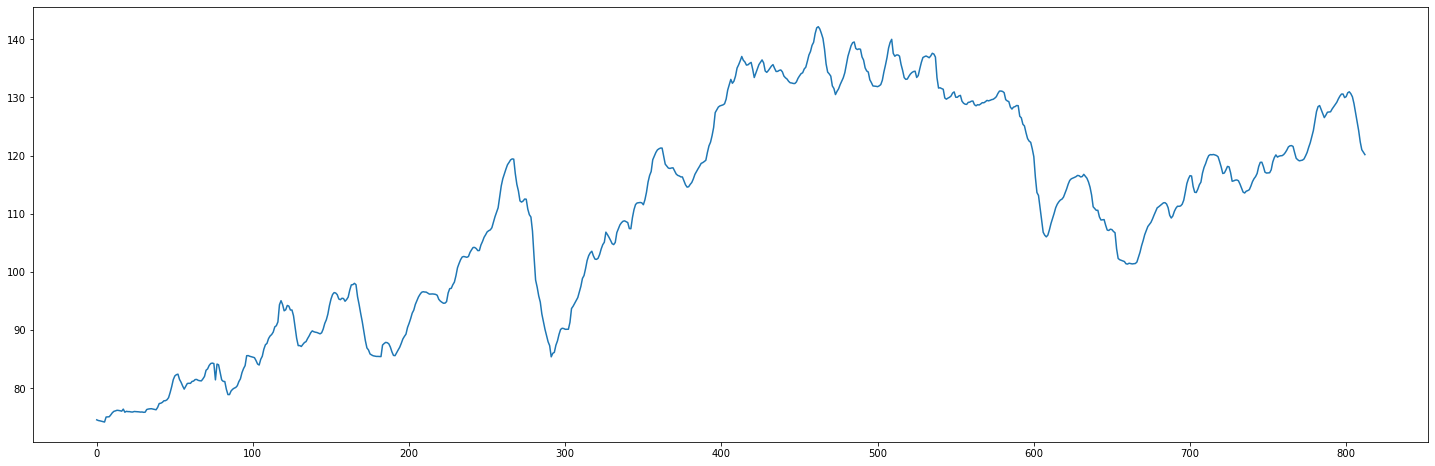

In [19]:
df['Petrol (USD)'].plot(figsize=(25,8))

In [20]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [21]:
adfuller_test(df['Petrol (USD)'])

ADF Test Statistic : -2.07969194896319
p-value : 0.25275858171724164
#Lags Used : 7
Number of Observations Used : 805
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [22]:
df['seasonal_first_difference'] = df['Petrol (USD)']-df['Petrol (USD)'].shift(7)
adfuller_test(df['seasonal_first_difference'].dropna())

ADF Test Statistic : -4.847785221500399
p-value : 4.402393567065211e-05
#Lags Used : 21
Number of Observations Used : 784
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:>

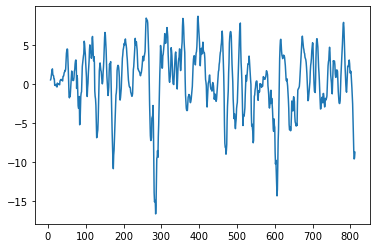

In [25]:
df['seasonal_first_difference'].plot()

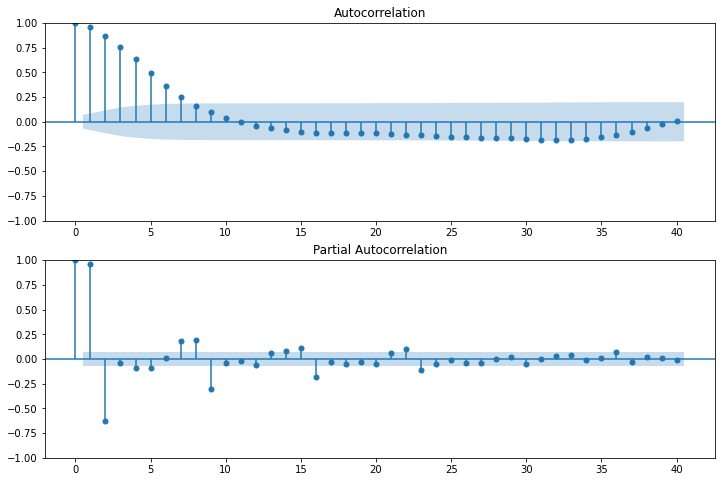

In [26]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_first_difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_first_difference'].dropna(),lags=40,ax=ax2)

In [27]:
df = df.drop('seasonal_first_difference',axis=1)

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.head()

,Petrol (USD)
Date,
2003-06-09,74.59
2003-06-16,74.47
2003-06-23,74.42
2003-06-30,74.35
2003-07-07,74.28


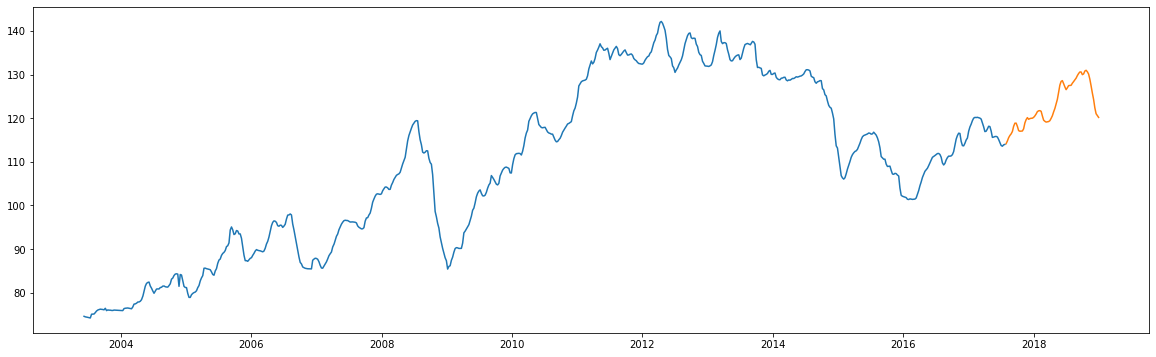

In [37]:
plt.figure(figsize=(20,6))
train_split = df[:738]
test_split = df[-75:]
plt.plot(train_split)
plt.plot(test_split)

In [38]:
arima_model = auto_arima(train_split,start_p=0,d=1,start_q=0,max_p=5,max_d=5,max_q=5,
                         start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=12,seasonal=True,
                         error_action='warn',trace=True,supress_warnings=True,stepwise=True,
                         random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2312.600, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1730.307, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1920.282, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1645.766, Time=0.48 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1567.806, Time=0.91 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1549.651, Time=1.75 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1538.473, Time=3.34 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=14.98 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=7.44 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1901.235, Time=2.06 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1539.590, Time=4.08 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=1539.521, Time=4.93 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=1650.643, Time=3.25 sec
 ARIMA(2,1,1)(5,1,0)[12]         

In [39]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  738
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -762.237
Date:                            Wed, 08 Jun 2022   AIC                           1538.473
Time:                                    16:46:35   BIC                           1570.576
Sample:                                         0   HQIC                          1550.863
                                            - 738                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6357      0.021     30.612      0.000       0.595       0.676
ar.S.L12      -0.8369      0.031    -27.096      0.000      -0.897      -0.776
ar.S.L24      -0.7027      0.040    -17.553      0.000      -0.781      -0.624
ar.S.L36      -0.5410      0.048    -11.254      0.000      -0.635      -0.447
ar.S.L48      -0.2765      0.047     -5.922      0.000      -0.368      -0.185
ar.S.L60      -0.1335      0.037     -3.608      0.000      -0.206      -0.061
sigma2         0.4708      0.015     32.006      0.000       0.442       0.500
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               732.28
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.10
Prob(H) (two-sided):                  0.46   Kurtosis:                         7.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
prediction = pd.DataFrame(arima_model.predict(n_periods=75),index=test_split.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
Date,
2017-07-31,113.801618
2017-08-07,113.720610
2017-08-14,113.913666
2017-08-21,114.170841
2017-08-28,114.426919
...,...
2018-12-03,118.668487
2018-12-10,118.768199
2018-12-17,118.316250


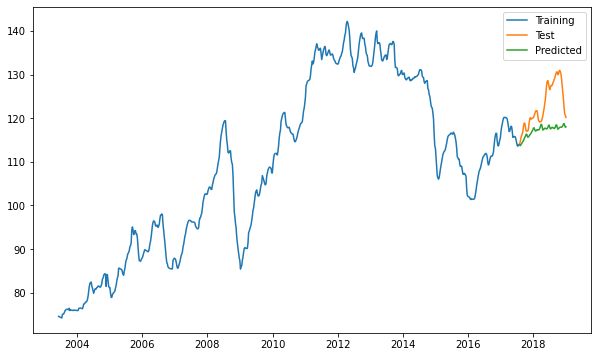

In [41]:
plt.figure(figsize=(10,6))
plt.plot(train_split,label='Training')
plt.plot(test_split,label='Test')
plt.plot(prediction,label='Predicted')
plt.legend()
plt.show()

In [42]:
def MAPE(y_true,y_pred):
    mape = np.mean(np.abs((y_true-y_pred)/y_true))*100
    return mape

In [43]:
MAPE(test_split['Petrol (USD)'],prediction['predicted_sales'])

4.565580947467188

Using statistical model we get MAPE score of 4.565, Now trying to find the MAPE score of Machine learning models

In [48]:
df = df.reset_index()
df.head()

,Date,Petrol (USD)
0,2003-06-09,74.59
1,2003-06-16,74.47
2,2003-06-23,74.42
3,2003-06-30,74.35
4,2003-07-07,74.28


In [49]:
## for train data
## converting Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
## Extracting year,month,day,dayofyear,dayofweek,weekofyear to get more insights of data
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofweek'] = df['Date'].dt.dayofweek
df['weekofyear'] = df['Date'].dt.weekofyear
df = df.drop('Date',axis=1)
df.head()

,Petrol (USD),year,month,day,dayofyear,dayofweek,weekofyear
0,74.59,2003,6,9,160,0,24
1,74.47,2003,6,16,167,0,25
2,74.42,2003,6,23,174,0,26
3,74.35,2003,6,30,181,0,27
4,74.28,2003,7,7,188,0,28


In [50]:
## for test data
## converting Date to datetime
df_test['Date'] = pd.to_datetime(df_test['Date'])
## Extracting year,month,day,dayofyear,dayofweek,weekofyear to get more insights of data
df_test['year'] = df_test['Date'].dt.year
df_test['month'] = df_test['Date'].dt.month
df_test['day'] = df_test['Date'].dt.day
df_test['dayofyear'] = df_test['Date'].dt.dayofyear
df_test['dayofweek'] = df_test['Date'].dt.dayofweek
df_test['weekofyear'] = df_test['Date'].dt.weekofyear
df_test = df_test.drop(['Date','Prediction'],axis=1)
df_test.head()

,year,month,day,dayofyear,dayofweek,weekofyear
0,2019,1,1,1,1,1
1,2019,1,2,2,2,1
2,2019,1,3,3,3,1
3,2019,1,4,4,4,1
4,2019,1,5,5,5,1


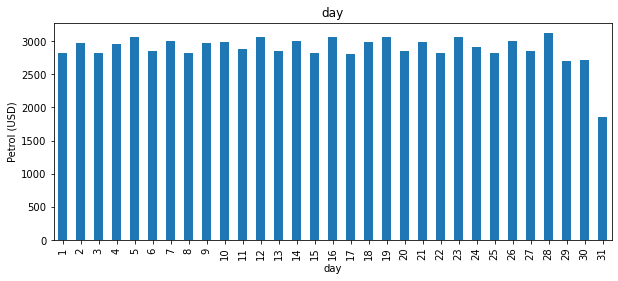

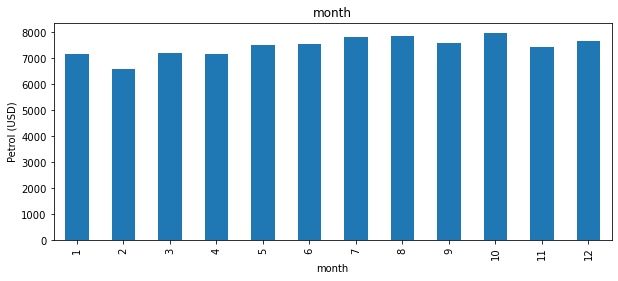

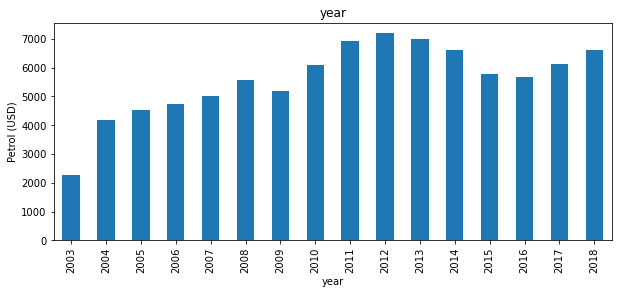

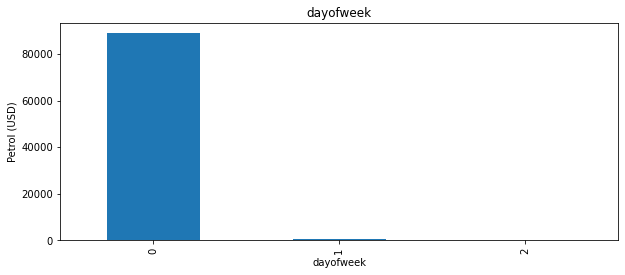

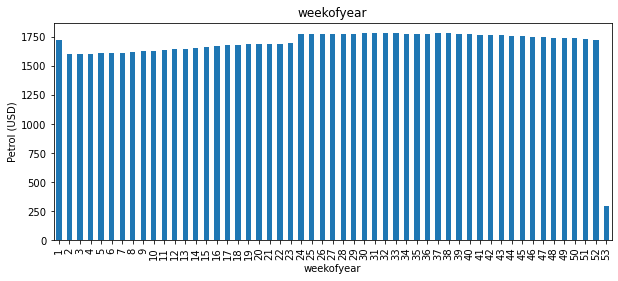

In [22]:
### visualizing the features with target column

for i in ['day','month','year','dayofweek','weekofyear']:
    plt.figure(figsize=(10,4))
    df.groupby(i)['Petrol (USD)'].sum().plot.bar()
    plt.xlabel(i)
    plt.ylabel('Petrol (USD)')
    plt.title(i)
    plt.show()

#### Analysis:

- The petrol price gradually increases from 2003 and reaches a peak on 2012,gradually decreases till 2016 and starts increasing again.
- 2012 has recorded the highest petrol price among all the years from 2003 till 2018.

### Correlation

<AxesSubplot:>

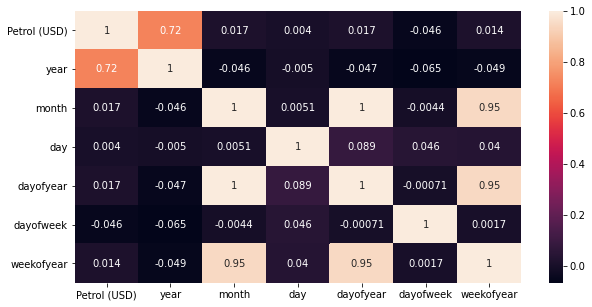

In [23]:
df_correlation = df.corr()
plt.figure(figsize=(10,5))
sns.heatmap(df_correlation,annot=True)

#### Analysis

The features such as month,dayofyear,weekofyear is correlated.

#### Calculating VIF score

In [24]:
## scaling the data while calculating vif score
def vif_score(data,col):
    y = data[col]
    X = data.drop([col],axis=1)
    scalar = StandardScaler()
    X_scaled = scalar.fit_transform(X)
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
    vif["Features"] = X.columns
    return vif

In [25]:
vif_score(df,'Petrol (USD)')

,VIF,Features
0,1.008910,year
1,20496.198246,month
2,144.982746,day
3,20645.604580,dayofyear
4,1.007435,dayofweek
5,10.267064,weekofyear


Many features are with vif score greater than 5

#### Removing Correlated features

In [26]:
def remove_corr_features(corr,data,col):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    selected_columns = data.columns[columns]
    dataset_corr = data[selected_columns]
    return vif_score(dataset_corr,col),dataset_corr

In [27]:
## After removing correlated features
df_vif,df = remove_corr_features(df_correlation,df,'Petrol (USD)')
df_vif

,VIF,Features
0,1.006417,year
1,1.002201,month
2,1.002157,day
3,1.006422,dayofweek


In [28]:
## dayofyear and weekofyear is removed based on correlation
df.head()

,Petrol (USD),year,month,day,dayofweek
0,74.59,2003,6,9,0
1,74.47,2003,6,16,0
2,74.42,2003,6,23,0
3,74.35,2003,6,30,0
4,74.28,2003,7,7,0


In [29]:
df_test = df_test.drop(['dayofyear','weekofyear'],axis=1)
df_test.head()

,year,month,day,dayofweek
0,2019,1,1,1
1,2019,1,2,2
2,2019,1,3,3
3,2019,1,4,4
4,2019,1,5,5


### Model building

In [30]:
## Seperating the train data for splitting
y = df['Petrol (USD)']
X = df.drop(['Petrol (USD)'],axis=1)

In [87]:
X.shape

(813, 4)

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [32]:
## Training the model
models={
    'Linear Regression': LinearRegression(),
    'Linear Regression(Ridge)': Ridge(),
    'Linear Regression(lasso)': Lasso(),
    'Support vector Regression': SVR(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'Catboost': CatBoostRegressor(verbose=0),
    'Light Gradient boosting': LGBMRegressor()
}

for model_name,model in models.items():
    model.fit(X_train,y_train)
    print(model_name,'trained')

Linear Regression trained
Linear Regression(Ridge) trained
Linear Regression(lasso) trained
Support vector Regression trained
Random Forest Regressor trained
XGBoost Regressor trained
Catboost trained
Light Gradient boosting trained


In [33]:
## Calculating RMSE score for each model

for model_name,model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test-y_pred)**2))
    print(model_name,"RMSE: {:.2f}".format(rmse))

Linear Regression RMSE: 13.10
Linear Regression(Ridge) RMSE: 13.07
Linear Regression(lasso) RMSE: 12.99
Support vector Regression RMSE: 19.26
Random Forest Regressor RMSE: 1.41
XGBoost Regressor RMSE: 1.43
Catboost RMSE: 1.86
Light Gradient boosting RMSE: 2.33


In [34]:
## Calculating MAPE score for each model

for model_name,model in models.items():
    y_pred = model.predict(X_test)
    mape = np.mean(np.abs((y_test-y_pred)/y_test))*100
    print(model_name,"MAPE: {:.3f}".format(mape))

Linear Regression MAPE: 10.123
Linear Regression(Ridge) MAPE: 10.108
Linear Regression(lasso) MAPE: 10.083
Support vector Regression MAPE: 16.434
Random Forest Regressor MAPE: 0.874
XGBoost Regressor MAPE: 0.983
Catboost MAPE: 1.138
Light Gradient boosting MAPE: 1.619


Random forest regressor has the least MAPE score comapred to all models.Tried this data using fbprophet model gave high rmse score, more than linear regression

In [77]:
## function to calculate MAPE
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test-y_pred)/y_test))*100
    return mape

In [78]:
rf_model = RandomForestRegressor(random_state=100)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
mape = MAPE(y_test,y_pred)
mape

0.8894236360662385

### Hyperparameter tuning

Hyperparameter tuning with grid search cv gives mape score of 5.63 which is way higher than base model, Hence calculating using randomized search cv

In [37]:
params = {
    'n_estimators': [90,100,115,130],
    'max_depth': range(2,20,1),
    'min_samples_split':range(2,10,1),
    'min_samples_leaf': range(2,10,1),
    'max_features':['auto','sqrt','log2']
}

In [38]:
rs = RandomizedSearchCV(estimator=rf_model,param_distributions=params,cv=5,n_jobs=-1,verbose=1)
rs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 20),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(2, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': [90, 100, 115, 130]},
                   verbose=1)

In [39]:
rs.best_params_

{'n_estimators': 90,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 13}

In [40]:
rfrs_model = RandomForestRegressor(n_estimators=90,
 min_samples_split= 8,
 min_samples_leaf= 5,
 max_features='auto',
 max_depth=15)
rfrs_model.fit(X_train,y_train)
y_pred_rfrs = rfrs_model.predict(X_test)
mape = MAPE(y_test,y_pred_rfrs)
mape

1.5602333473817216

This is very much higher than the base model, hence again tuning the model

In [41]:
params1 = {
    'n_estimators': [50,100,125,170,200],
    'criterion':['mse','mae','poisson'],
    'min_samples_split':[4,5,6,7,8],
    'min_samples_leaf': [1,2,3,4,5],
    'min_impurity_decrease':range(1,5,1),
    'max_samples':range(1,10),
    'max_features':['auto','sqrt','log2']
}

In [42]:
rs = RandomizedSearchCV(estimator=rf_model,param_distributions=params1,cv=5,n_jobs=-1,verbose=1)
rs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae', 'poisson'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': range(1, 10),
                                        'min_impurity_decrease': range(1, 5),
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [4, 5, 6, 7, 8],
                                        'n_estimators': [50, 100, 125, 170,
                                                         200]},
                   verbose=1)

In [43]:
rs.best_params_

{'n_estimators': 170,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'min_impurity_decrease': 4,
 'max_samples': 9,
 'max_features': 'auto',
 'criterion': 'mae'}

In [44]:
rfrs_model = RandomForestRegressor(n_estimators=50,
 min_samples_split= 5,
 min_samples_leaf= 3,
 min_impurity_decrease= 2,
 max_features='log2',
 max_samples=7,
 criterion='mae')
rfrs_model.fit(X_train,y_train)
y_pred_rfrs = rfrs_model.predict(X_test)
mape = MAPE(y_test,y_pred_rfrs)
mape

13.40953945894264

That's a lot, Hence after tuning with different parameter, got the model with least mape score 

In [45]:
rfrs_model= RandomForestRegressor(n_estimators=200,
 min_samples_split=2,
 min_samples_leaf=1,
 max_features='auto',
 max_depth=14,
 min_impurity_decrease=0.0000001,                                  
 random_state=100)
rfrs_model.fit(X_train,y_train)
y_pred_rfrs = rfrs_model.predict(X_test)
mape = MAPE(y_test,y_pred_rfrs)
mape

0.8750644791053342

In [47]:
## Predicting for test data
y_pred = rfrs_model.predict(df_test)
test['Prediction'] = y_pred
## storing the results in a csv file
test.to_csv('test_result.csv',index=False)
test

,Date,Prediction
0,1/1/2019,120.43270
1,1/2/2019,120.43270
2,1/3/2019,120.43270
3,1/4/2019,120.77650
4,1/5/2019,120.77650
5,1/6/2019,120.77420
6,1/7/2019,120.79580
7,1/8/2019,120.74635
8,1/9/2019,120.90875
9,1/10/2019,120.90875


In [98]:
for i in range(len(test)):
    print(test.iloc[i,0],test.iloc[i,1])

1/1/2019 120.4326999999998
1/2/2019 120.4326999999998
1/3/2019 120.4326999999998
1/4/2019 120.77649999999986
1/5/2019 120.77649999999986
1/6/2019 120.77419999999985
1/7/2019 120.79579999999983
1/8/2019 120.74634999999975
1/9/2019 120.90874999999994
1/10/2019 120.90874999999994
1/11/2019 121.11049999999999
1/12/2019 121.11049999999999
1/1/2020 120.4326999999998
1/2/2020 120.4326999999998
1/3/2020 120.4326999999998
1/4/2020 120.77649999999986
